In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Завантаження данних

In [2]:
rts1 = pd.read_csv('./rts1.txt', squeeze=True, header=None, names=['rts1'])
rts1.head()

0    2296.56
1    2306.87
2    2313.90
3    2339.79
4    2330.87
Name: rts1, dtype: float64

In [3]:
rts1996 = pd.read_csv('./1996rts1.txt', squeeze=True, header=None, names=['1996rts1'])
rts1996.head()

0    87.35
1    90.78
2    91.19
3    89.99
4    90.73
Name: 1996rts1, dtype: float64

### Ковзне середнє

In [4]:
def sma(data, N):
    sma = data.rolling(N).mean()
    sma.name += f' SMA (N={N})'
    return sma


def ema(data, N, return_weights=False):
    a = 2 / (N + 1)
    w = [(1 - a)**n for n in range(N, 0, -1)]
    ema = data.rolling(N).apply(lambda window: (w * window).sum() / sum(w))
    ema.name += f' EMA (N={N})'
    return (ema, w) if return_weights else ema

#### Значення вагових коефіцієнтів для експоненційного КС

In [5]:
ema(rts1, 5, return_weights=True)[1]

[0.13168724279835398,
 0.19753086419753096,
 0.2962962962962964,
 0.44444444444444453,
 0.6666666666666667]

In [6]:
ema(rts1, 10, return_weights=True)[1]

[0.13443063274931186,
 0.16430410669360337,
 0.20081613040329305,
 0.2454419371595804,
 0.2999845898617094,
 0.3666478320532004,
 0.44812512806502275,
 0.5477084898572501,
 0.6694214876033057,
 0.8181818181818181]

#### Графіки індексу та ковзних середніх

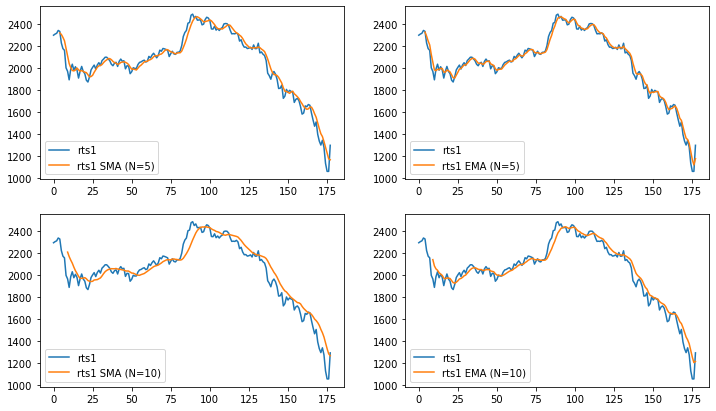

In [7]:
fig, ax = plt.subplots(2, 2, figsize=(12, 7))

for i, n in enumerate([5, 10]):
    plt.sca(ax[i, 0])
    rts1.plot()
    sma(rts1, n).plot()
    plt.legend()

    plt.sca(ax[i, 1])
    rts1.plot()
    ema(rts1, n).plot()
    plt.legend()

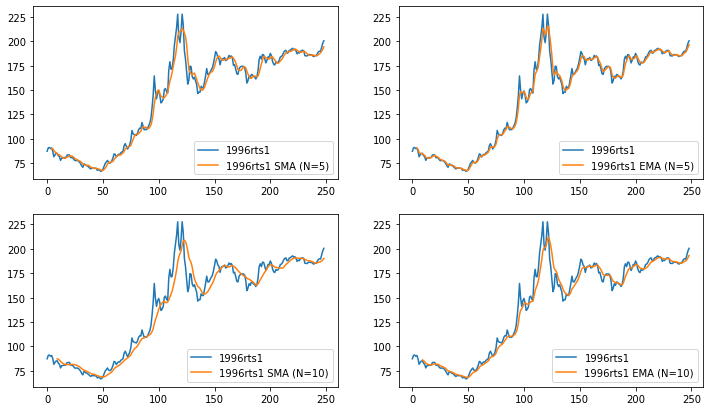

In [8]:
fig, ax = plt.subplots(2, 2, figsize=(12, 7))

for i, n in enumerate([5, 10]):
    plt.sca(ax[i, 0])
    rts1996.plot()
    sma(rts1996, n).plot()
    plt.legend()

    plt.sca(ax[i, 1])
    rts1996.plot()
    ema(rts1996, n).plot()
    plt.legend()

### ЧАКФ

In [9]:
def r_(data):
    return [ ((data - data.mean()) * (data.shift(s) - data.mean())).sum()
            / ((data.size - 1) * data.var())
            for s in range(1, data.size+1)]

def pacf(data, maxlag=None):
    N = maxlag if maxlag else data.size
    r = r_(data)
    phi = np.zeros((N, N))
    phi[0, 0] = r[0]
    
    for k in range(1, N):
        sum_top = sum([ phi[k-1, j]*r[k-1-j] for j in range (0, k)])
        sum_bottom = sum([ phi[k-1, j]*r[j] for j in range (0, k)])
        phi[k, k] = (r[k] - sum_top) / (1 - sum_bottom)
        
        for j in range(0, k):
            phi[k, j] = phi[k-1, j] - phi[k, k]*phi[k-1, k-1-j]
            phi[j, k] = phi[k, j]
            
    return np.diag(phi)


In [10]:
pacf(rts1, 12)

array([ 0.96618053, -0.24787356,  0.03959292, -0.00335798,  0.09927818,
       -0.06352588, -0.03033853,  0.01719459,  0.06074584,  0.04110425,
       -0.06515567, -0.00820221])

Порівняємо з функцією зі стандартного пакета

In [11]:
from statsmodels.tsa import stattools
stattools.pacf(rts1, nlags=12, method='ywm')[1:]

array([ 0.96618053, -0.24787356,  0.03959292, -0.00335798,  0.09927818,
       -0.06352588, -0.03033853,  0.01719459,  0.06074584,  0.04110425,
       -0.06515567, -0.00820221])